## Introduction

Before starting data analysis we look on the data that we have in csv file, here we can see an example of one of the files:

In [1]:
import pandas

PREVIEW = pandas.read_csv('../../../data-adaptation/data_example.csv')
PREVIEW

,Counter(/amcl/parameter_descriptions),Mean_Consecutive(/amcl/parameter_descriptions),Messages-Age(/amcl/parameter_descriptions),Counter(/amcl/parameter_updates),Mean_Consecutive(/amcl/parameter_updates),Messages-Age(/amcl/parameter_updates),Counter(/amcl_pose),Mean_Consecutive(/amcl_pose),Messages-Age(/amcl_pose),Counter(/clock),...,/rosout Delivered,/rosout_agg Active Connections,/rosout_agg Dropped,/rosout_agg Delivered,/scan Active Connections,/scan Dropped,/scan Delivered,/tf Active Connections,/tf Dropped,/tf Delivered
0,1,0,0.0,1,0,0.0,1,0,1.513790e+18,94,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0.0,0,0,0.0,0,0,0.000000e+00,1054,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0.0,0,0,0.0,0,0,0.000000e+00,869,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0.0,0,0,0.0,1,0,1.513790e+18,877,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0.0,0,0,0.0,0,0,0.000000e+00,925,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329,0,0,0.0,0,0,0.0,1,0,1.513790e+18,829,...,0,0,0,0,0,0,0,0,0,0
330,0,0,0.0,0,0,0.0,0,0,0.000000e+00,850,...,0,0,0,0,0,0,0,0,0,0
331,0,0,0.0,0,0,0.0,0,0,0.000000e+00,688,...,0,0,0,0,0,0,0,0,0,0
332,0,0,0.0,0,0,0.0,1,0,1.513790e+18,939,...,0,0,0,0,0,0,0,0,0,0


##### Basic column name meaning

- Counter() - this column shows number of topic message publishings in period of time (one clock unit of the ROS)
- Mean_Consecutive() - mean time between topic message publishings in one period of time
- Message-Age() - system time when message was published

The original data contains 406 columns with different data measurements. For starting processing it we need to do two things:
1. We need to filter the columns with not relavent data like timestamps and zero value columns (columns where all values are zero).
2. Data represenation is not normalized, so just before start working on it we need to find correct normalization rule to save original data meaning and dependencies. After these two steps we got pure data that we combined into one file:

##### Normal data preview

In [2]:
DATA = pandas.read_csv('../../../data-adaptation/merged.csv')
DATA


,Counter(/clock),Mean_Consecutive(/clock),Counter(/host_diagnostic),Mean_Consecutive(/host_diagnostic),Counter(/joint_states),Mean_Consecutive(/joint_states),Counter(/kinect2/qhd/camera_info),Mean_Consecutive(/kinect2/qhd/camera_info),Counter(/kinect2/qhd/image_color/compressed),Mean_Consecutive(/kinect2/qhd/image_color/compressed),...,Threads(/move_base),MeanLoadCPU(/move_base),matansar(MinCPU0),matansar(StdCPU0),matansar(MinCPU1),matansar(StdCPU1),matansar(MinCPU2),matansar(StdCPU2),matansar(MinCPU3),matansar(StdCPU3)
0,416,0.001114,2,0.580318,35,0.021638,6,0.026784,3,0.045631,...,11.0,17.000000,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18
1,920,0.001083,2,0.561588,46,0.021695,14,0.065842,10,0.105388,...,11.0,19.445455,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18
2,905,0.001100,2,0.555192,45,0.022060,12,0.080915,9,0.112184,...,11.0,17.590000,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18
3,934,0.001067,2,0.512376,47,0.021101,10,0.083380,9,0.105279,...,11.0,18.133333,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18
4,941,0.001061,2,0.525791,47,0.021254,14,0.065183,10,0.105074,...,11.0,17.009091,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17870,980,0.001020,2,0.510422,49,0.019995,12,0.073625,10,0.103233,...,11.0,9.681818,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18
17871,929,0.001076,2,0.553366,46,0.021433,14,0.073147,9,0.106950,...,11.0,9.666667,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18
17872,953,0.001047,2,0.523317,48,0.020427,12,0.057224,10,0.104793,...,11.0,8.754546,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18
17873,912,0.001091,2,0.561547,46,0.021688,12,0.079705,9,0.111040,...,11.0,8.610000,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18


##### Anomaly data preview

In [3]:
ANOMALY_DATA = pandas.read_csv('../../../data-adaptation/merged_test.csv')
ANOMALY_DATA

,Counter(/clock),Mean_Consecutive(/clock),Counter(/host_diagnostic),Mean_Consecutive(/host_diagnostic),Counter(/joint_states),Mean_Consecutive(/joint_states),Counter(/kinect2/parameter_descriptions),Counter(/kinect2/parameter_updates),Counter(/kinect2/qhd/camera_info),Mean_Consecutive(/kinect2/qhd/camera_info),...,Threads(/move_base),MeanLoadCPU(/move_base),matansar(MinCPU0),matansar(StdCPU0),matansar(MinCPU1),matansar(StdCPU1),matansar(MinCPU2),matansar(StdCPU2),matansar(MinCPU3),matansar(StdCPU3)
0,469,0.001026,2,0.518104,34,0.020897,1,1,6,0.050149,...,11.0,11.820000,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18
1,897,0.001115,2,0.550576,45,0.022322,0,0,12,0.071620,...,11.0,13.577778,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18
2,865,0.001155,2,0.565974,43,0.023229,0,0,12,0.059923,...,11.0,11.910000,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18
3,946,0.001051,2,0.530423,48,0.021028,0,0,14,0.073898,...,11.0,11.945455,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18
4,949,0.001044,2,0.520119,48,0.021061,0,0,14,0.064801,...,11.0,11.488889,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1023,822,0.001080,1,0.000000,40,0.021743,0,0,12,0.068342,...,11.0,12.580000,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18
1024,1027,0.000952,2,0.473058,51,0.019016,0,0,12,0.069623,...,11.0,15.580000,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18
1025,917,0.001091,2,0.539508,46,0.021793,0,0,14,0.067429,...,11.0,17.455556,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18
1026,841,0.001188,2,0.595000,42,0.023028,0,0,12,0.072452,...,11.0,15.320000,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18,9.220000e+18


For normalization we choose `MinMaxScaler` with value range between $\left[1, -1\right]$

In [4]:
import torch

from autoencoder import Autoencoder
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from torch.autograd import Variable
from tqdm import tqdm
import os
from sklearn.decomposition import PCA
import datetime
from IPython.display import Image


#### Constants and definitions

In [5]:
print("Running directory:",os.getcwd())

# CONSTS
TEST_PURPOSE = False

USE_PCA = True
SAVE_IMAGES = False
SAVE_MODEL_EACH_EPOCH = False
TRAIN_LSTM = False
EPOCHS = 100

Running directory: /Users/igorvinokur/Development/Dev/Study/generative-model/py/model/autoencoder


Choosing device for training LSMT

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:",device)

Device: cpu


#### Data processing utils

In [8]:
scalers = {}

def normalize_data(original_data):
    """
    This function used for normalizing data, with MinMaxScaler.
    Each scaler saved in the external object for future use of de-transformation
    :param original_data: data from the file
    :return: normlized data in the same format as received
    """
    norm_data = original_data
    for i in original_data.columns:
        scaler = None
        if ('scaler_' + i) not in scalers:
            scaler = MinMaxScaler(feature_range=(-1, 1))
        else:
            scaler = scalers['scaler_' + i]
        s_s = scaler.fit_transform(norm_data[i].values.reshape(-1, 1))
        s_s = np.reshape(s_s, len(s_s))
        scalers['scaler_' + i] = scaler
        norm_data[i] = s_s
    return norm_data

def unnormalize_data(columns, reconstructed_data):
    """
    This function is normalization inverse function.
    :param columns: orinal columns names, used for taking correct scaler that was saved while normalization
    :param reconstructed_data: normalized data
    :return: unnormalized data 
    """
    restored_data = []
    for (i, name) in enumerate(columns):
        restored_data.append(np.array(scalers['scaler_' + name].inverse_transform(reconstructed_data[:,i].reshape(-1, 1))).flatten())
    return np.array(restored_data)


def split_data(data, window):
    """
    Data split for train and labels with sliding window
    :param data: original data
    :param window: subsequence length
    :return:
    """
    train_x = data[:window + 1]
    x, y = sliding_windows(train_x, 1)
    train_x = Variable(torch.Tensor(np.array(x)))
    train_y = Variable(torch.Tensor(np.array(y)))
    return train_x, train_y


def sliding_windows(data, seq_length):
    """
    Sliding window transformation for the data
    :param data: original data
    :param seq_length: window size
    :return: two arrays of x and y
    """
    x = []
    y = []
    for i in range(len(data)-seq_length):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)

def ploy_data(norm_data, anomaly_norm_data, current_run_dir, title="Data"):
    """
    This function plot two-column data of normal and anomaly data on the same plot.
    This function also saves plots as images
    :param norm_data: two columns of normal data
    :param anomaly_norm_data: two columns of anomaly data
    :param current_run_dir: directory for saving plot images
    :param title: title of the plot
    """
    fig, axs = plt.subplots(1, figsize=(10, 10))
    axs.scatter(norm_data[:,0], norm_data[:,1], label="Normal", color="g")
    axs.scatter(anomaly_norm_data[:,0], anomaly_norm_data[:,1], label="Anomaly", color="r")
    axs.set_title(title)
    axs.legend()
    plt.legend()
    if SAVE_IMAGES:
        plt.savefig(os.getcwd() + os.sep + 'res' + os.sep + current_run_dir + os.sep + title.replace("/", "_"))
    plt.show()
    plt.close()

def filter_column_indexs(columns, other_columns):
    """
    This function used for filtering one column array by another
    :param columns:
    :param other_columns:
    :return: intersection of two lists
    """
    filtered = []
    for c in other_columns:
        if c in columns:
            filtered.append(columns.index(c))
    return filtered

### LSTM Train

For trying undestand connection between measurements (we have 73 columns of it) we tried to run LSTM Autoencoder to detect anomalies in the data offline.

##### Model Structure
- Encoder: we stacked two LSTM network each one receiving 73 inputs (features), each stack has 37 hidden layers as an output of the encoder.
- Decoder: same stacked LSTM network, just input now has 37 features and output has 73

The sequence length in each batch is defined as parameter and the current value is 60 measurements (each 73 features).

For loss function we are using MSELoss and Adam optimazer with learning rate of 0.001

In [9]:
def train(model, train_data, test_data, anomaly_norm_data, current_run_dir=None):
    """
    This function used for training LSTM.
    :param model: - LSTM model
    :param train_data: X
    :param test_data: X^
    :param anomaly_norm_data: normalized anomaly data for testing training process
    :param current_run_dir: directory for saving images
    """
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    objective = nn.MSELoss().to(device)
    history = []
    test_losses = []
    anomaly_losses = []
    for e in tqdm(range(EPOCHS)):
        model.train()
        loss = 0
        test_loss = 0
        anomaly_loss = 0
        for i in tqdm(range(len(train_data))):
            x = train_data[i]
            x = torch.Tensor(np.array([x])).to(device)
            optimizer.zero_grad()
            reconstructed = model(x)
            loss = objective(reconstructed, x)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            optimizer.step()
            if i % 1000 == 0:
                print("\n========== \nEpoch: ", e, " Seq: ", i, "\n=============")
        history.append(loss.item())
        with torch.no_grad():
            model.eval()
            x = torch.Tensor(np.array([test_data])).to(device)
            reconstruction = model(x)
            test_loss = objective(reconstruction, x)
            test_losses.append(test_loss.item())
            # anomaly
            x = torch.Tensor(np.array([anomaly_norm_data])).to(device)
            reconstruction = model(x)
            anomaly_loss = objective(reconstruction, x)
            anomaly_losses.append(anomaly_loss.item())
        # if e % 10 == 0:
        if SAVE_MODEL_EACH_EPOCH:
            torch.save(model.state_dict(), "res" + os.sep + current_run_dir + os.sep + "epoch_" + str(e) + ".model")
        print("================================")
        print('Epoch: ', e);
        print("Loss: ", loss.item())
        print("Test Loss: ", test_loss.item())
        print("Anomaly Loss: ", anomaly_loss.item())
        print("================================")
    return history, test_losses, anomaly_losses

def predict(model, dataset):
    """
    Predicting from trained model
    :param model: trained model
    :param dataset: data
    :return reconstructed data
    """
    predictions = []
    with torch.no_grad():
        model = model.eval()
        x = torch.Tensor(np.array([dataset])).to(device)
        reconstruction = model(x)
    return reconstruction.squeeze(0)


#### PCA

In [48]:
def use_pca(norm_data, DATA, n_components=0.90):
    """
    This function is running PCA on the normilized data
    :param norm_data: normalized data
    :param DATA: original dataframe
    :param n_components: varience of importance of the data column
    :return only important columns that PCA choose
    """
    pca = PCA(n_components=n_components)
    pca.fit_transform(norm_data)
    n_pcs = pca.n_components_
    most_important = [[np.abs(pca.components_[i]).argmax(), pca.components_[i].max()] for i in range(n_pcs)]
    most_important = sorted(most_important , key=lambda a_entry: -a_entry[1])
    initial_feature_names = DATA.columns
    most_important_column_names = [initial_feature_names[most_important[i][0]] for i in range(n_pcs)]
#     print('Most important columns number ', len(most_important_column_names))
#     print('Most important columns', most_important_column_names)
    NEW_DATA = norm_data[most_important_column_names].values
    return NEW_DATA, most_important_column_names

In [11]:
def main():
    current_run_dir = datetime.datetime.now().strftime("%d-%m-%Y_%H%M%S")
    os.mkdir(os.getcwd() + os.sep + 'res' + os.sep + current_run_dir)
    norm_data, columns = DATA.values, DATA.columns
    n_features = len(columns)
    if USE_PCA:
        norm_data, columns = use_pca(normalize_data(DATA.copy()), DATA)
        n_features = len(columns)
    else:
        norm_data, columns = normalize_data(DATA.copy()).values, list(DATA.columns.values)
        n_features = len(DATA.columns)

    anomaly_columns = ANOMALY_DATA.columns
    # find intersected columns
    inter_columns = np.intersect1d(columns, anomaly_columns)
    inter_columns = [x for _, x in sorted(zip(columns, inter_columns), key=lambda pair: pair[0])]
    anomaly_norm_data = normalize_data(ANOMALY_DATA.copy())[inter_columns].values
    # take only data with intersected columns
    filtered_index = filter_column_indexs(columns, inter_columns)
    norm_data = norm_data[:, filtered_index]
    columns = inter_columns

    for i in range(len(norm_data[0]) - 2):
        nd = norm_data[:, i:i+2]
        a_nd = anomaly_norm_data[:, i:i+2]
        c = ', '.join(columns[i:i+2])
        ploy_data(nd, a_nd, current_run_dir, c)

    norm_data = norm_data[:, :2]
    columns = columns[:2]
    anomaly_norm_data = anomaly_norm_data[:, :2]
    n_features = len(columns)
    print(n_features)
    ploy_data(norm_data, anomaly_norm_data, current_run_dir, ', '.join(columns))

    if TEST_PURPOSE:
        norm_data = norm_data[:200]

    if not TRAIN_LSTM:
        return
    
    lstm_stacks = 2
    autoencoder_input = n_features
    encoder_hidden_layers = int(n_features/2)
    decoder_input = n_features
    seq_len = 60
    autoencoder_output = n_features
    
    autoencoder = Autoencoder(lstm_stacks,
                              autoencoder_input,
                              encoder_hidden_layers,
                              decoder_input,
                              seq_len,
                              autoencoder_output).to(device)
    train_size = np.int(len(norm_data) * 0.8)
    train_data, test_data = norm_data[:train_size], norm_data[train_size:]
    train_x, train_y = sliding_windows(train_data, seq_len)
    h, l, a = train(autoencoder, train_x, test_data, anomaly_norm_data, current_run_dir)
    
    print(h)
    print(l)
    fig, axs = plt.subplots(1)
    
    axs.plot(range(len(h)), h, label="Train loss")
    axs.plot(range(len(l)), l, label="Test loss")
    axs.plot(range(len(a)), a, label="Anomaly loss")
    axs.set_title('Losses')
    axs.legend()
    plt.legend()
    plt.savefig(os.getcwd() + os.sep + 'res' + os.sep + current_run_dir + os.sep + 'train_test')
    plt.show()
    plt.close()
    torch.save(autoencoder.state_dict(), "res" + os.sep + current_run_dir + os.sep + "final.model")
    reconstruction = predict(autoencoder, test_data)
    reconstruction = unnormalize_data(columns, reconstruction.cpu().numpy())
    
    original = DATA[columns].values[:len(test_data)]
    for i in range(len(reconstruction)):
        plt.figure(figsize=(30, 10))
        plt.plot(range(len(reconstruction[i])), reconstruction[i], label="Reconstructed " + columns[i])
        plt.plot(range(len(original[:,i])), original[:,i], label="Original " + columns[i])
        plt.legend()
        plt.show()
        plt.savefig(os.getcwd() + os.sep + 'res' + os.sep + current_run_dir + os.sep + str(i))
        plt.close()
    
    file = open(os.getcwd() + os.sep + 'res' + os.sep + current_run_dir + os.sep + 'model_params.txt', "w+")
    file.writelines([
        'lstm_stacks='+str(lstm_stacks),
        '\n\rautoencoder_input='+str(autoencoder_input),
        '\n\rencoder_hidden_layers='+str(encoder_hidden_layers),
        '\n\rdecoder_input='+str(decoder_input),
        '\n\rseq_len='+str(seq_len),
        '\n\rautoencoder_output=' + str(autoencoder_output)
    ])
    file.close()

# Experiments

Here short descrition of all experiments we run. 

First we tried to run LSTM autoencoder on the whole range of features (73 columns), we can see the results on the next plot

![Train Test results on 73 features](./notebook-asstets/train_test.png "Results 1")

However in this experiment we have a problem. We are using two dimentional loss function to measure distance in 73 dimentional space so it cause not percise results and maybe also completely wrong results. (all other plots are placed [here](./res)).

The second idea was to run PCA on the original data and take only important columns (in our case with varience of 0.9 it give us 13 columns) and run LSTM Autoencoder on them. It gives us pretty same results because it still too many dimentions for MSELoss.

## Run training and test

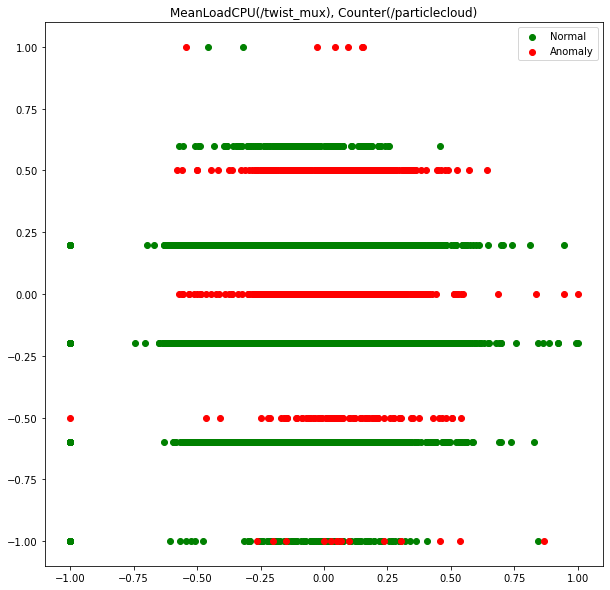

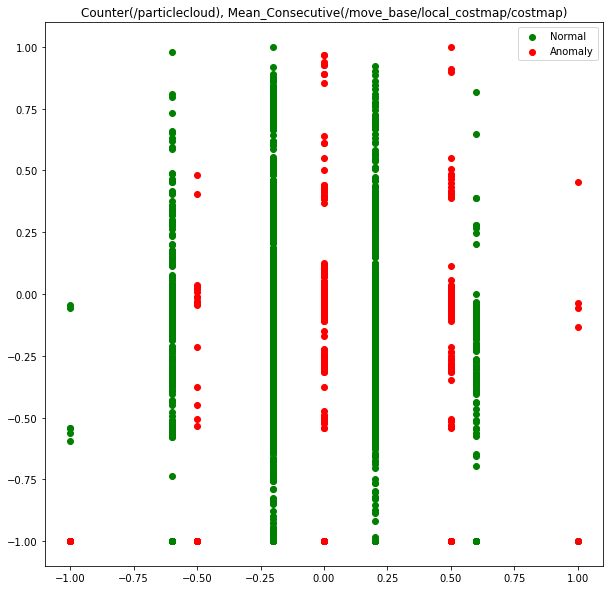

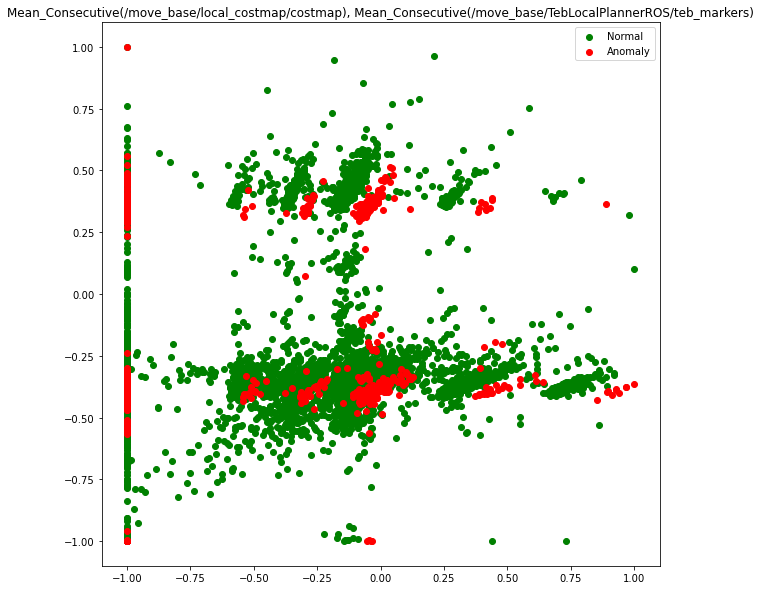

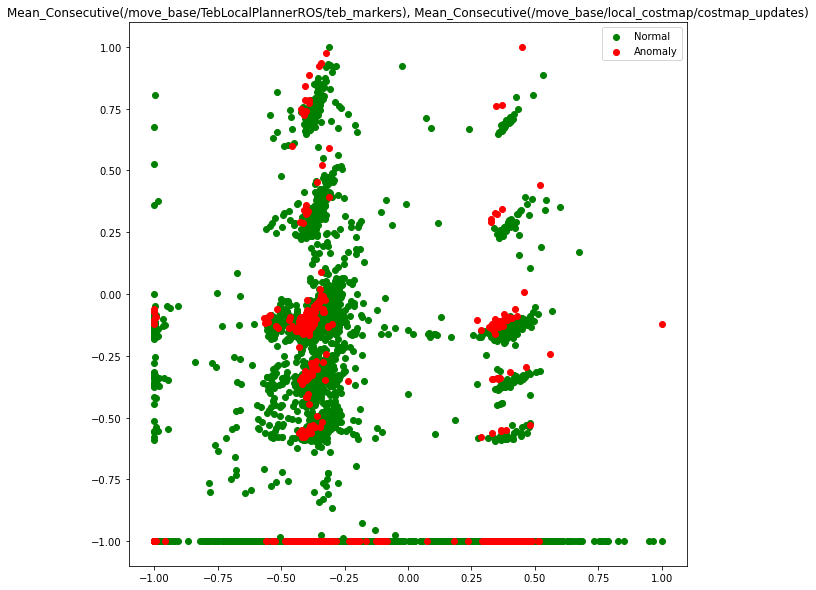

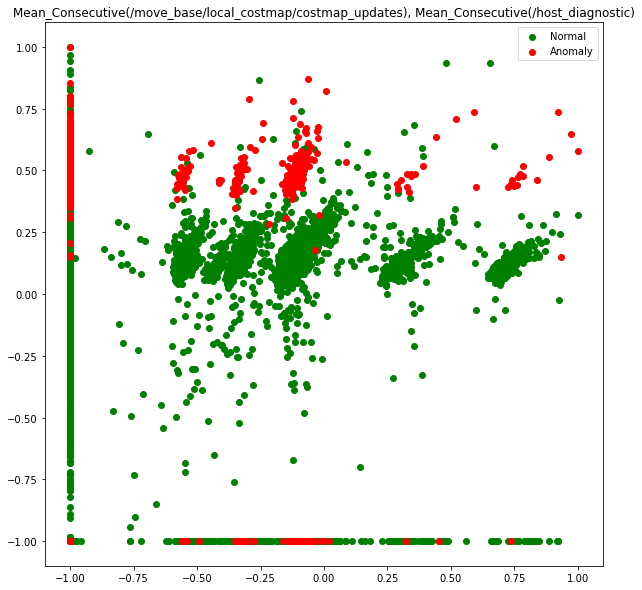

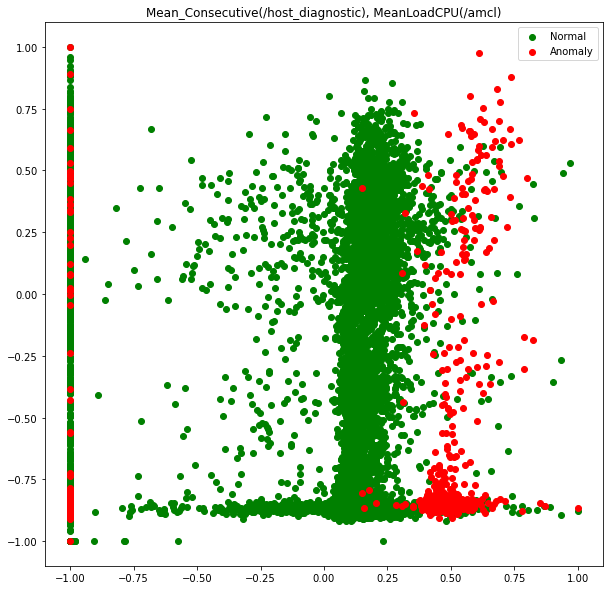

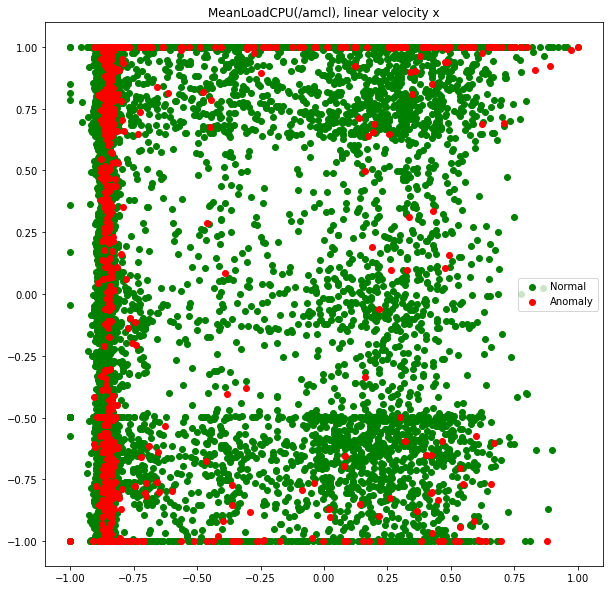

2


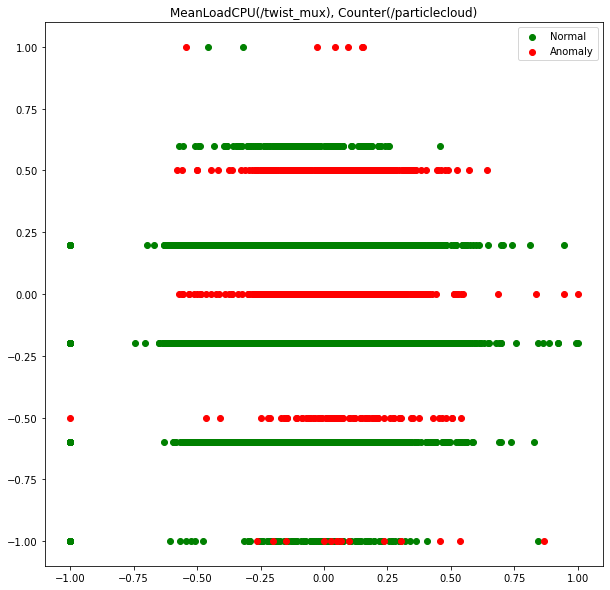

In [49]:
main()

On the plots above we can see the behavior of the data of the PCA choosen columns. Green data points are normal data and red are anomaly.

Already from these plots we can see that data is separable and LSTM Autoencoder can easilly converge.

## Experiments with data

##### Choosing common columns

While looking on the data we saw that there are small difference in the columns of anomaly and normal data, so we tried to find common columns.

In [12]:
columns = DATA.columns
anomaly_columns = ANOMALY_DATA.columns
common_columns = np.intersect1d(columns, anomaly_columns)
common_columns = [x for _, x in sorted(zip(columns, common_columns), key=lambda pair: pair[0])]
anomaly_norm_data = normalize_data(ANOMALY_DATA.copy())[common_columns].values
print(anomaly_norm_data.shape)

(1028, 71)


#### Running PCA and taking only two columns

In [19]:
norm_data = normalize_data(DATA[common_columns].copy())
print('Original dataset shape:', norm_data.shape)
pca = PCA(n_components=0.9)
new_data = pca.fit_transform(norm_data)
n_pcs = pca.n_components_
most_important = [[np.abs(pca.components_[i]).argmax(), np.abs(pca.components_[i]).max()] for i in range(n_pcs)]
most_important = sorted(most_important , key=lambda a_entry: -a_entry[1])
most_important_data_fragment = pandas.DataFrame(most_important, columns=['Index of column', 'PCA coefficient'])
most_important_data_fragment

Original dataset shape: (17875, 71)


,Index of column,PCA coefficient
0,15,0.807374
1,30,0.769483
2,45,0.741393
3,59,0.718888
4,12,0.691078
5,23,0.656097
6,52,0.642728
7,54,0.629880
8,30,0.625120
9,16,0.555479


The table above shows us indexes of most importent columns in the data by the PCA and their coefficient values

In [44]:
initial_feature_names = DATA.columns
most_important_column_names = [initial_feature_names[most_important[i][0]] for i in range(n_pcs)]
most_important_column_names_df = pandas.DataFrame(most_important_column_names, columns=['Column name'])
most_important_column_names_df

,Column name
0,Mean_Consecutive(/mobile_base_controller/odom)
1,Counter(/move_base/local_costmap/costmap)
2,Mean_Consecutive(/pan_tilt_trajectory_controll...
3,Threads(/twist_mux)
4,Counter(/mobile_base_controller/cmd_vel)
5,Mean_Consecutive(/move_base/TebLocalPlannerROS...
6,Counter(/scan)
7,Counter(/tf)
8,Counter(/move_base/local_costmap/costmap)
9,Counter(/move_base/NavfnROS/plan)


##### Topics
`/mobile_base_controller/odom` - Control is in the form of a velocity command, that is split then sent on the two wheels of a differential drive wheel base. Odometry is computed from the feedback from the hardware, and published.

`/move_base/local_costmap/costmap` - The navigation stack uses two costmaps to store information about obstacles in the world. One costmap is used for global planning, meaning creating long-term plans over the entire environment, and the other is used for local planning and obstacle avoidance. 

`/pan_tilt_trajectory_controller/follow_joint_trajectory/status` - Controller for executing joint-space trajectories on a group of joints. Trajectories are specified as a set of waypoints to be reached at specific time instants, which the controller attempts to execute as well as the mechanism allows. Waypoints consist of positions, and optionally velocities and accelerations.

`/twist_mux` - Twist multiplexer, which multiplex several velocity commands (topics) and allows to priorize or disable them (locks).

`/mobile_base_controller/cmd_vel` - Sending velocity updates

`/move_base/TebLocalPlannerROS/teb_markers` - The teb_local_planner provides additional information of the planning scene via markers with different namespaces. Namespaces PointObstacles and PolyObstacles: visualize all point and polygon obstacles that are currently considered during optimization. Namespace TebContainer: Visualize all found and optimized trajectories that rest in alternative topologies (only if parallel planning is enabled). Some more information is published such as the optimization footprint model

`/scan` - Absctact topic of scanning environment. Each package has topic for scanning environment for it's own purposes.

`/tf` - is a package that lets the user keep track of multiple coordinate frames over time. tf maintains the relationship between coordinate frames in a tree structure buffered in time, and lets the user transform points, vectors, etc between any two coordinate frames at any desired point in time.

`/move_base/NavfnROS/plan` - The last plan computed by navfn, published everytime the planner computes a new path, and used primarily for visualization purposes.

###### Summary: 
After looking on column (topic) properties we can undestand that all of them are relavent to the movement of the robot. So we can assume that PCA did correct selection.

#### PCA Components analysis

Next experiment we performed was to analyze PCA components manually and undestand which columns influence the most on the PCA, so we can use them in our calculations.

From the result of PCA we took only first two features (linear combinations) and performed all test on them. These two features are has largest varience.

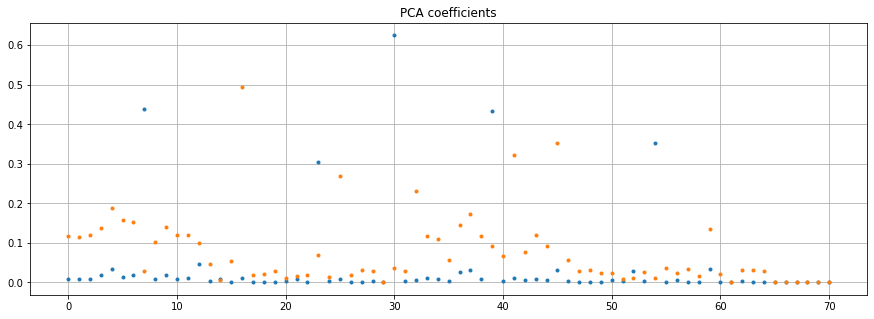

In [42]:
two_cols = pca.components_[:2, :]
fig, axs = plt.subplots(1, figsize=(15, 5))
axs.plot(abs(two_cols.T), ".")
axs.set_title('PCA coefficients')
plt.grid()
plt.show()
plt.close()

From the plot above we can see that not all features are important in the data. We desided to take only values with threshold of 0.2 and what is below just set 0. 

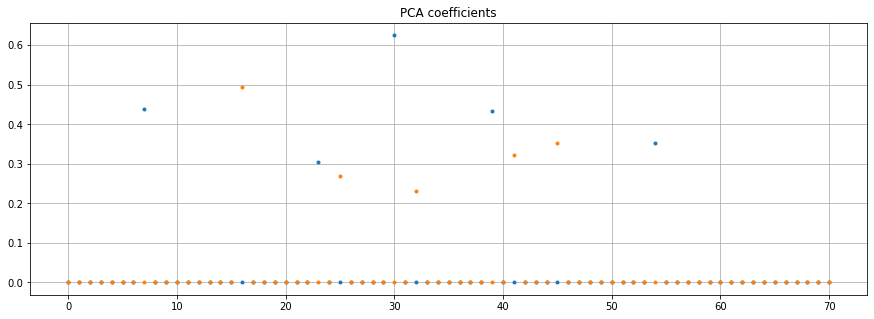

In [46]:
important_pca_comp = two_cols
important_pca_comp = np.where(abs(important_pca_comp) <= 0.2, 0, important_pca_comp)
fig, axs = plt.subplots(1, figsize=(15, 5))
axs.plot(abs(important_pca_comp.T), ".")
axs.set_title('PCA coefficients')
plt.grid()
plt.show()
plt.close()


As the result of filtering we got only 10 points which mean that we have only 10 features of the original data will play major role in the linear transformation on the data we perform next.

##### Building linear combinations from important PCA components and original normilized data

So we took the list of components from the above plot and we multiply them by original and anomly normalized data as we show next: 

$$x = [x_1, x_2,...,x_{73}]\\$$
$$a = [0,0,0,..,a_n,0,..,a_k,0,...a_m,0...]\\\\
\tilde{y} = x \cdot a$$

(17875, 2)
(1028, 2)


Text(0.5, 1.0, 'Lineary transformed data')

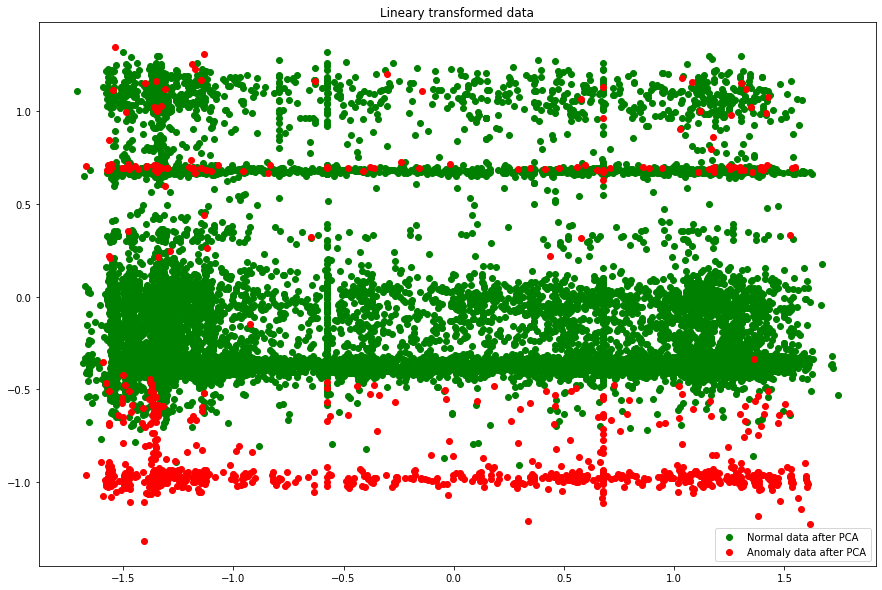

In [140]:
fig, axs = plt.subplots(1, figsize=(15, 10))
normal_pca_data = important_pca_comp.dot(norm_data.T).T
anomaly_pca_data = important_pca_comp.dot(anomaly_norm_data.T).T
print(normal_pca_data.shape)
print(anomaly_pca_data.shape)
axs.scatter(normal_pca_data[:,0], normal_pca_data[:,1], color="g", label="Normal data after PCA")
axs.scatter(anomaly_pca_data[:,0], anomaly_pca_data[:,1], color="r", label="Anomaly data after PCA")
axs.legend()
axs.set_title('Lineary transformed data')

On the plot above we plot 2 columns of normal and anomaly data (x axis is first column, y axis is second column).

The plot show as very good separation of the data in the case of anomaly. Again we still need to test visualy analysing data and maybe running LSTM Autonecoder on it.

So let's start with visual analysing.

### PCA linear combination visual analysis

In [143]:
def data_slicing(norm_data, anomaly_norm_data, pca_comp, normal_i, anomaly_i, \
                 normal_window_size=300, anomaly_window_size=60, title=""):
    normal_data_slice = norm_data.values[normal_i:normal_i + normal_window_size,:]
    anomaly_data_slice = anomaly_norm_data[anomaly_i:anomaly_i + anomaly_window_size,:]
    fig, axs = plt.subplots(nrows=1, ncols=3, squeeze=False, figsize=(17, 5))
    sliced_pca_data = pca_comp.dot(normal_data_slice.T).T
    asliced_pca_data = pca_comp.dot(anomaly_data_slice.T).T
    axs[0][0].plot(sliced_pca_data[:,0], sliced_pca_data[:,1], color='g', label="Normal data")
    axs[0][0].plot(asliced_pca_data[:,0], asliced_pca_data[:,1], color='r', label="Anomaly data")
    axs[0][1].plot(sliced_pca_data[:,0], sliced_pca_data[:,1], color='g', label="Normal data")
    axs[0][2].plot(asliced_pca_data[:,0], asliced_pca_data[:,1], color='r', label="Anomaly data")
    axs[0][0].legend()
    axs[0][0].set_title('Anomaly and normal')
    axs[0][1].legend()
    axs[0][1].set_title('Index:' + str(normal_i) + ' window: ' + str(normal_window_size))
    axs[0][2].legend()
    axs[0][2].set_title('Index:' + str(anomaly_i) + ' window: ' + str(anomaly_window_size))
    plt.show()
    plt.close()

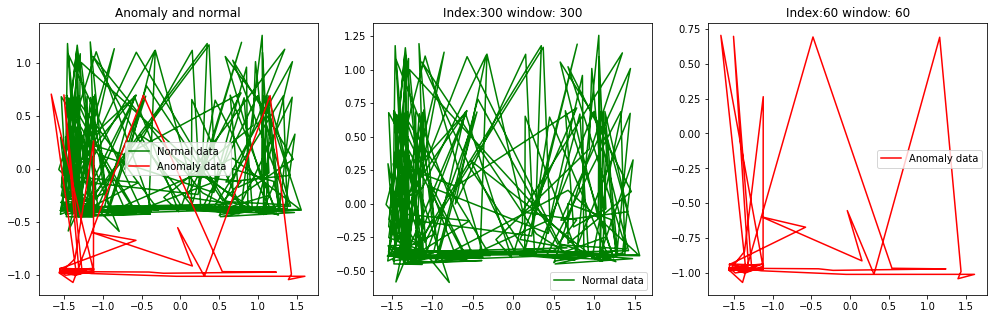

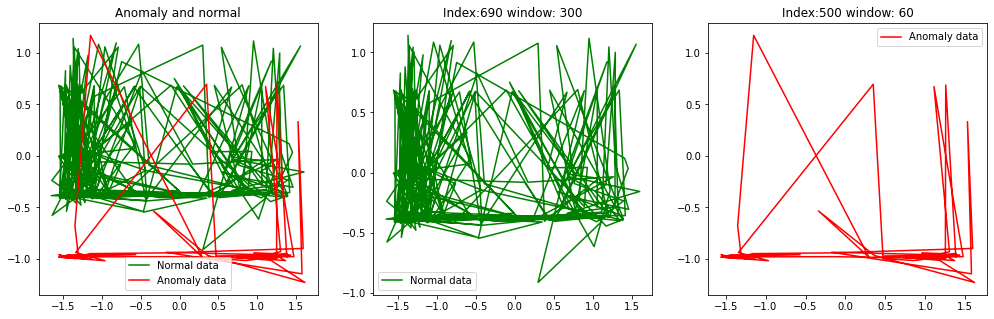

In [144]:
nw_size = 300
aw_size = 60
data_slicing(norm_data, anomaly_norm_data, important_pca_comp, 300, 60, nw_size, aw_size)
data_slicing(norm_data, anomaly_norm_data, important_pca_comp, 690, 500, nw_size, aw_size)

From visual analysis of trajectories of the data is very hard to assume something. From the plot of linear transformed data we can see clear separation of the data so we need to try to find this separations to undestand what is going on.

From the plot of the dots we can see that the most red points are around value 0.5 and -1. Let's try to find indexes of those values and plot them as trajectories

(200, 2)
(60, 2)


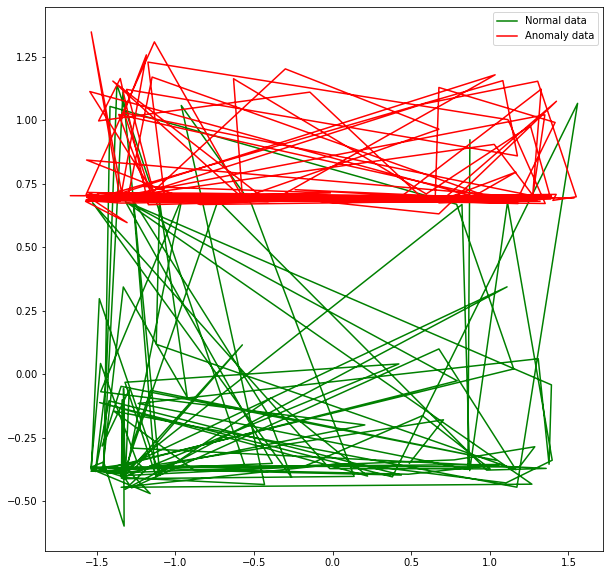

In [145]:
indxs = np.argwhere(anomaly_pca_data[:,1] >= 0.5)

fig, axs = plt.subplots(1, figsize=(10, 10))

normal_pca_data = important_pca_comp.dot(norm_data.T).T
anomaly_pca_data = important_pca_comp.dot(anomaly_norm_data.T).T
print(sliced_pca_data.shape)
print(asliced_pca_data.shape)
axs.plot(normal_pca_data[indxs,0], normal_pca_data[indxs,1], color='g', label="Normal data")
axs.plot(anomaly_pca_data[indxs,0], anomaly_pca_data[indxs,1], color='r', label="Anomaly data")
axs.legend()

As we can see from the above plot, there is an intersection of red and green lines, so let's try to find those indexes and plot the trajectories

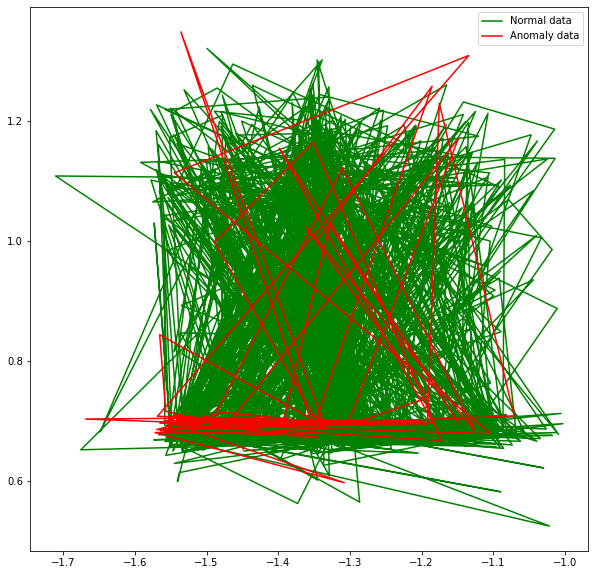

In [146]:
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

ay_indxs = np.argwhere(anomaly_pca_data[:,1] >= 0.5)
ax_indxs = np.argwhere(anomaly_pca_data[:,0] <= -1)
a_inter_indxs = intersection(ay_indxs, ax_indxs)

ny_indxs = np.argwhere(normal_pca_data[:,1] >= 0.5)
nx_indxs = np.argwhere(normal_pca_data[:,0] <= -1)
n_inter_indxs = intersection(ny_indxs, nx_indxs)

fig, axs = plt.subplots(1, figsize=(10, 10))

axs.plot(normal_pca_data[n_inter_indxs,0], normal_pca_data[n_inter_indxs,1], color='g', label="Normal data")
axs.plot(anomaly_pca_data[a_inter_indxs,0], anomaly_pca_data[a_inter_indxs,1], color='r', label="Anomaly data")
axs.legend()

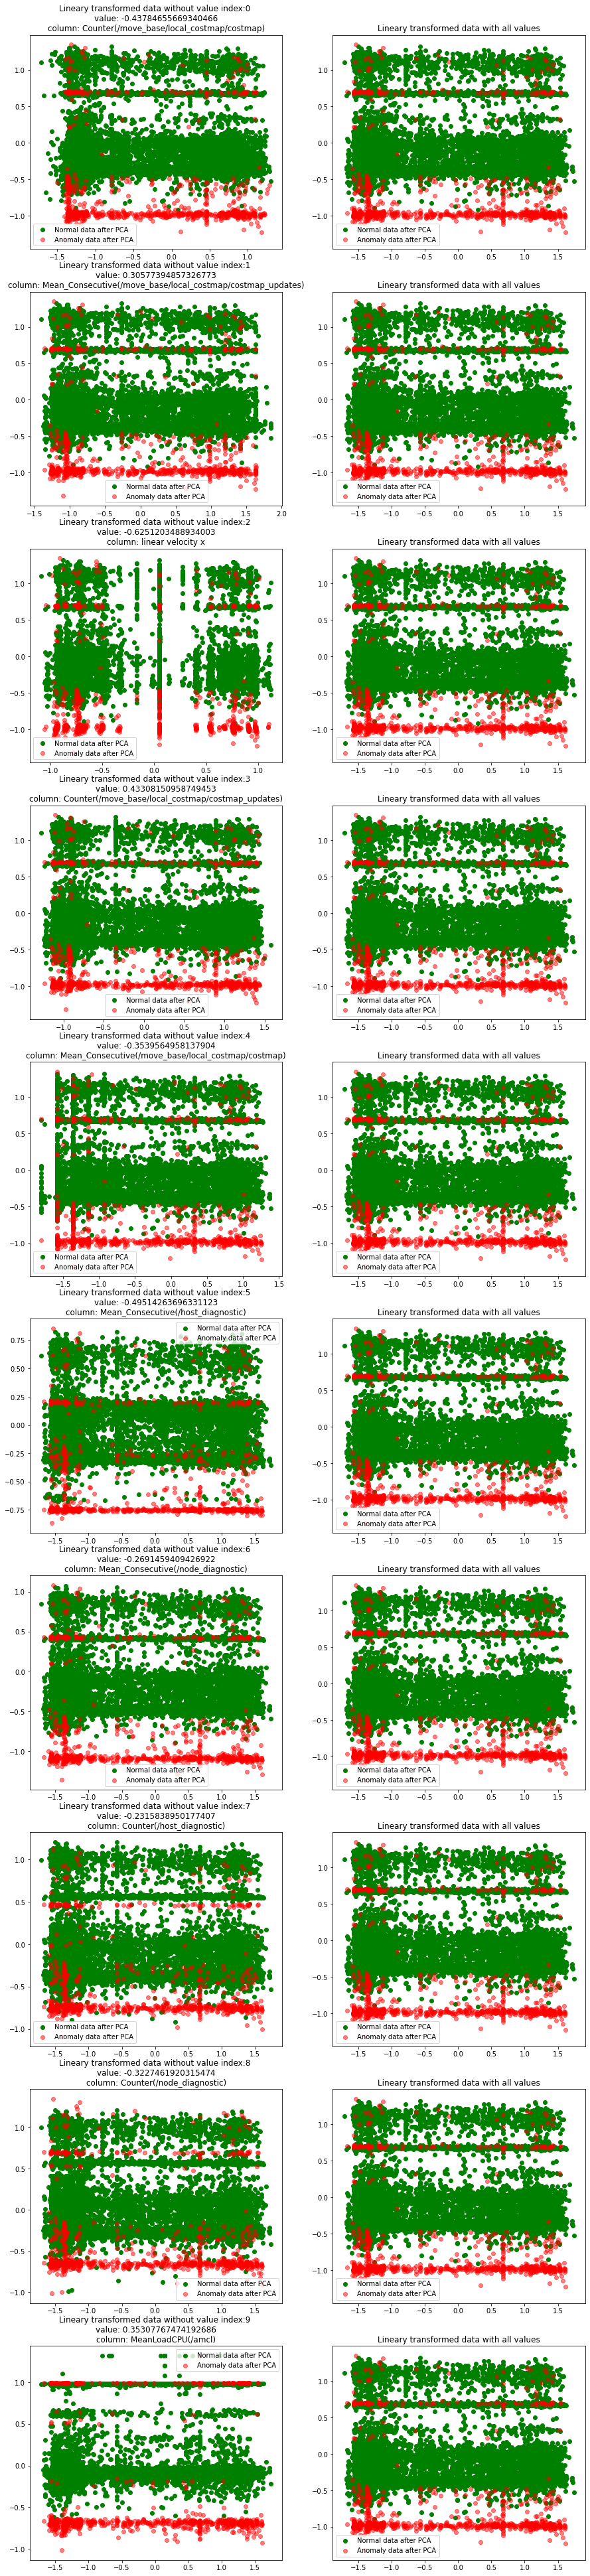

In [171]:
most_important_indexs = np.argwhere(important_pca_comp != 0)
fig, axs = plt.subplots(len(most_important_indexs), 2, figsize=(15, 70))
for i, ij in enumerate(most_important_indexs):
    copy_pca_comp = important_pca_comp.copy()
    copy_pca_comp[ij[0], ij[1]] = 0
    n = copy_pca_comp.dot(norm_data.T).T
    a = copy_pca_comp.dot(anomaly_norm_data.T).T
    axs[i][0].scatter(n[:,0], n[:,1], color="g", label="Normal data after PCA")
    axs[i][0].scatter(a[:,0], a[:,1], color="r", label="Anomaly data after PCA", alpha=0.5)
    axs[i][0].legend()
    axs[i][0].set_title('Lineary transformed data without value index:' + str(i) + ' \nvalue: '\
                     + str(important_pca_comp[ij[0], ij[1]]) + \
                        '\ncolumn: ' + common_columns[ij[1]])
    axs[i][1].scatter(normal_pca_data[:,0], normal_pca_data[:,1], color="g", label="Normal data after PCA")
    axs[i][1].scatter(anomaly_pca_data[:,0], anomaly_pca_data[:,1], color="r", label="Anomaly data after PCA", alpha=0.5)
    axs[i][1].legend()
    axs[i][1].set_title('Lineary transformed data with all values')

From those plots we can see that if we put 0 on value with index 2 (second important coefficient) it changese data behavior.

Let's try to run LSTM Autoencoder on first two linear combinations of PCA (irrelavent columns are 0).

### LSTM Autoencoder reuslt on PCA linear combinations

We run the same model as in previous experiment except the original data we used two features (linear combinations) from PCA. So the setup is next, 2 inputs (features), one hidden layer, 2 stacked LSTM per encoder and decoder, sequence length 60. 

Results are:

![Train Test results on 2 features from PCA](./notebook-asstets/pca_train_test.png "PCA Results 1")

We performed 5 additional tests with LSTM and data after PCA, we tried change LSTM Autoencoder params and to use SGD optimizer for training. 

Here we can see some results:

First setup is: 

```
lstm_stacks=4

autoencoder_input=2

encoder_hidden_layers=1

decoder_input=2

seq_len=20

autoencoder_output=2
```
![Train Test results on 2 features from PCA SGD](./notebook-asstets/train_test_sgd.png "PCA Results 1")

From the plot we can see that LSTM not learining after few epochs.

```
lstm_stacks=1

autoencoder_input=2

encoder_hidden_layers=1

decoder_input=2

seq_len=60

autoencoder_output=2
```

![Train Test results on 2 features from PCA SGD](./notebook-asstets/train_test_sgd_2.png "PCA Results 1")

After removing one stack of LSTM from encoder and decoder the network starts to learn.

```
lstm_stacks=1

autoencoder_input=2

encoder_hidden_layers=1

decoder_input=2

seq_len=200

autoencoder_output=2
```
![Train Test results on 2 features from PCA SGD](./notebook-asstets/train_test_sgd_3.png "PCA Results 1")
After increassing sequence length the network learns better

The last experiment was with next params:
```
lstm_stacks=2

autoencoder_input=2

encoder_hidden_layers=1

decoder_input=2

seq_len=200

autoencoder_output=2
```
![Train Test results on 2 features from PCA SGD](./notebook-asstets/train_test_sgd_4.png "PCA Results 1")

We change LSTM Autoencoder to be with 2 stacks and we got overfitting on training.


3. GMM